## Начало 

Проверим точность простой модели, состоящей из 3-х свёрточных слоёв.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pickle
import methods

Зададим место, где лежат файлы.

In [3]:
DATA_FOLDER = "data/zakladki"
CATEGORY_1 = "nezakl"
CATEGORY_2 = "zakl"

## Взглянем на данные 

nezakl training data length:  3101
zakl training data length:  3101
nezakl validation data length:  500
zakl validation data length:  500
nezakl test data length:  500
zakl test data length:  500


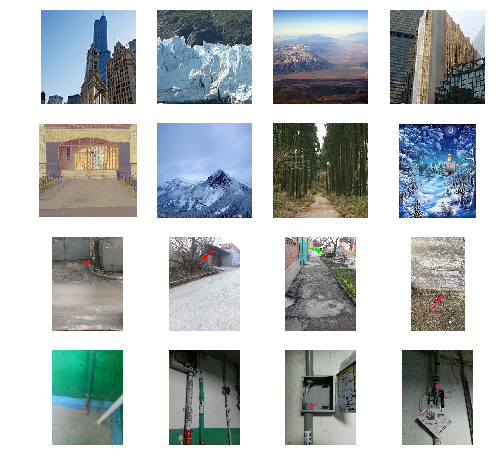

In [4]:
methods.visualize_data(DATA_FOLDER, CATEGORY_1, CATEGORY_2)

## Подготовим данные

In [23]:
image_size = 150
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1/255)
validation_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(
        DATA_FOLDER + '/train',
        target_size = (image_size, image_size),
        batch_size = batch_size,
        class_mode = 'binary'
)

validation_generator = validation_datagen.flow_from_directory(
        DATA_FOLDER + '/validation',
        target_size = (image_size, image_size),
        batch_size = batch_size,
        class_mode = 'binary'
)

test_generator = test_datagen.flow_from_directory(
        DATA_FOLDER + '/test',
        target_size = (image_size, image_size),
        batch_size = batch_size,
        shuffle=False,
        class_mode = "binary"
)

Found 6202 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Построим и обучим модель 

In [24]:
input_shape = (image_size, image_size, 3)

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: x, input_shape=input_shape),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 32)        0         
__________

In [27]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [28]:
epochs = 2
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

In [29]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      workers = 4,
      validation_data = validation_generator,
      validation_steps = validation_steps)

Epoch 1/2
194/194 [==============================] - 388s 2s/step - loss: 0.6308 - acc: 0.6737 - val_loss: 0.6803 - val_acc: 0.5580
Epoch 2/2
194/194 [==============================] - 385s 2s/step - loss: 0.5680 - acc: 0.7175 - val_loss: 0.6695 - val_acc: 0.5870


##  Сохраним результаты

Сохраним модель.

In [30]:
model.save("models/basicConvolution/basicConvolution.h5")

In [31]:
saved_model_path = "models/basicConvolution/"
tf.contrib.saved_model.save_keras_model(model, saved_model_path)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.


Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensor

b'models/basicConvolution/1564027315'

Сохраним историю обучения.

In [32]:
with open("histories/basicConvolution/basicConvolutionHistory", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

## Восстановим результаты 

Восстановим модель.

model_loaded = keras.models.load_model("models/basicConvolution/basicConvolution.h5")

Восстановим модель из .pb

model_loaded = tf.contrib.saved_model.load_keras_model("models/mobileNetV2/1563965428")

model_loaded.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

Восстановим историю обучения.

with open("histories/basicConvolution/basicConvolutionHistory", 'rb') as file_pi:
    history_loaded = pickle.load(file_pi)

## Посмотрим результаты 

Посмотрим графики обучения.

In [35]:
history_loaded = history.history

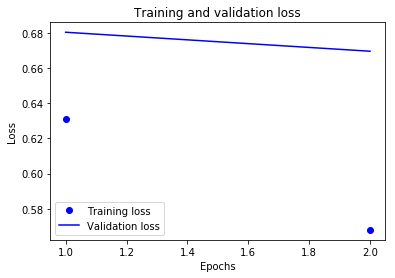

In [36]:
methods.loss(history_loaded)

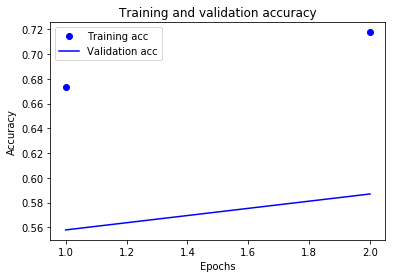

In [37]:
methods.acc(history_loaded)

Оценим параметры модели.

In [39]:
methods.AccRecPrec(model.predict_generator(test_generator), test_generator.classes)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
accuracy:  0.57
recall:    0.478
precision: 0.5857843
f1:        0.5264316805446067
